In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue

from plastockconf import name_zones, name_particles, name_frequentation, name_situation
from plastockconf import particle_groups, name_substrate, name_distance, table_css_styles

from plastock import add_table_to_page, capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary

# a_property =  {'color' : 'red'}

glue('blank_caption', " ", display=True)

def translate_describe(x, value_column, transpose: bool = False):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    if transpose:
        df = df.T
        
    return df
def translate_columns(data, columns, keys):
    
    for i, column in enumerate(columns):
        
        data[column] = data[column].apply(lambda x: keys[i][x])
    
    return data

def select_a_set_of_values(data, column_one, search_index, search_value, average_of_sample_formes):
    
    return data.loc[data[column_one] > average_of_sample_formes.loc[search_index, search_value]]

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
work_data["particules"] = work_data["compte"]
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

' '

(micro_atts)=
# Microplastiques plage et position

La position fait référence à l'emplacement de l'échantillon de microplastique sur la plage. La ligne d'eau correspond aux échantillons prélevés très près de l'endroit où l'eau rencontre le rivage. La plage sèche fait référence aux endroits de la plage qui sont plus éloignés de la ligne d'eau et qui sont généralement secs.

__Résultats agrégés par forme, position et échantillon__

In [2]:
# format_kwargs = dict(precision=2, thousands="'", decimal=",")

caption = 'Les données sont regroupées en trois groupes par échantillon: 1. fibres, 2. particules rigides, 3. particules souples.'
section = 'A'
rule = 'Les attributs dont la moyenne des résultats est supérieure à la moyenne du projet sont en rouge.'
page = 1
table_no =1

work_data_sample = work_data[work_data['échantillon'] == "74_Amp_2"].head()
work_data_sample['objet'] = work_data_sample.objet.apply(lambda x: particle_groups[x])
work_data_sample.set_index('objet', drop=True, inplace=True)
work_data_sample.index.name = None
work_data_sample = work_data_sample.style.set_table_styles(table_css_styles)
table_one = add_table_to_page(work_data_sample, table_no, caption, section, page, " ")
glue('tablea11', table_one, display=True)

,Plage,Échantillon,Orientation,Position,Substrat,Fréquentation,Situation,Distance,Compte,Particules
Particule rigide,Amphion,74_Amp_2,NNE,1,4,3,1,1,"3,00","3,00"
Fibre,Amphion,74_Amp_2,NNE,1,4,3,1,1,"121,00","121,00"
Particule souple,Amphion,74_Amp_2,NNE,1,4,3,1,1,"12,00","12,00"


## Nombre cumulé d'échantillons et particules par plage

In [3]:

sample_totals = work_data.groupby(["Plage","échantillon"], as_index=False).particules.sum()
value_column = "moyenne"

sample_averages = sample_totals.groupby("Plage", as_index=False).agg({"échantillon": "nunique", "particules":"mean"})
sample_averages.rename(columns={"particules":value_column}, inplace=True)
sample_averages.set_index("Plage", inplace=True, drop=True)


In [4]:
location_summary = work_data.groupby("Plage", as_index=False).agg({"échantillon": "nunique", "particules":"sum"})
location_summary["% échantillon"] = location_summary['échantillon']/location_summary['échantillon'].sum()
location_summary["% particules"] = location_summary.particules/location_summary.particules.sum()

# formatting for display
df1 = location_summary.copy()
df1.set_index("Plage", inplace=True, drop=True)

# map the average sample results to the beach
df1["moyenne"] = df1.index.map(lambda x: sample_averages['moyenne'].loc[x])

df1.index.name = None

# the colors used to highlight results
a_red_property =  {'color' : 'red'}
a_blue_property = { 'color': 'dodgerblue'}

# select the values where % of samples is less than the % of total particles
select_values = df1["% échantillon"] < df1["% particules"]

# select the values whose average is greater than 180
select_values2 = df1["moyenne"] > 180

# select the records according to the second test
test_two = df1[select_values2].index

# mask the datafranme for test one
test_one = df1.loc[select_values].index

# apply masks to table style
ttwo = df1.style.set_table_styles(table_css_styles).set_properties(subset=pd.IndexSlice[test_two, ["moyenne"]], **a_blue_property)
ttwo = ttwo.set_properties(subset = pd.IndexSlice[test_one,["% échantillon", "% particules"]], **a_red_property)

# add caption
caption1 = "Nombre cumulé d'échantillons et le total par plage. Les plages où le proportion du comptage est supérieur au proportion des échantillons sont en rouge."
caption2 = 'Les plages dont la moyenne des résultats est supérieure à la moyenne du projet sont en BLEU.'

caption = f'{caption1} {caption2}'

table_no +=1

table_two = add_table_to_page(ttwo, table_no, caption, section, page, " ")
glue('tablea12', table_two, display=True)

,Échantillon,Particules,% échantillon,% particules,Moyenne
Amphion,10,"1'287,00","0,05","0,03","128,70"
Anthy,6,"702,00","0,03","0,02","117,00"
Aubonne,8,"771,00","0,04","0,02","96,38"
Baby plage,11,"1'308,00","0,05","0,03","118,91"
Bouveret,11,"2'252,00","0,05","0,06","204,73"
Clarens,6,"431,00","0,03","0,01","71,83"
Crans,1,"19,00","0,00","0,00","19,00"
Cully,1,"128,00","0,00","0,00","128,00"
Excenevex,28,"4'319,00","0,13","0,11","154,25"
Gland,1,"40,00","0,00","0,00","40,00"


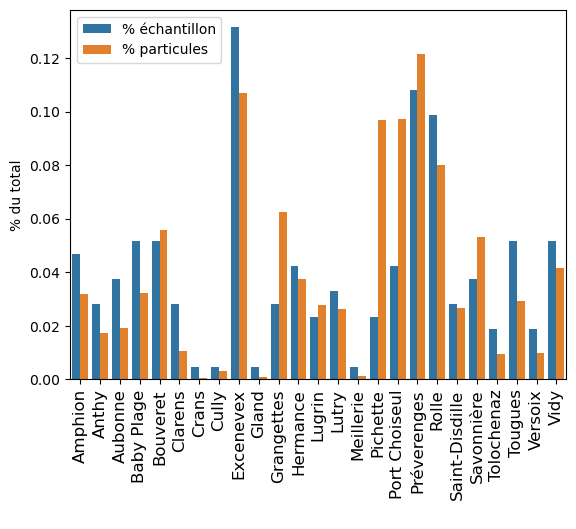

In [5]:
bar_plots = pd.melt(location_summary, id_vars="Plage", value_vars=["% échantillon", "% particules"])
fig, ax = plt.subplots()
sns.barplot(data=bar_plots, x="Plage", y="value", hue="variable", ax=ax)
ax.legend(loc="upper left")
ax.tick_params(axis="x", labelrotation=90, labelright=True, labelsize=12)
ax.set_ylabel('% du total')
ax.set_xlabel(" ")

glue('fig-A11', fig, display=True)
plt.close()

```{glue:figure} fig-A11
---
name: fig-A11
---
{glue:text}`blank_caption` 
```

In [6]:
attribute_columns = ["Plage", "orientation", "position", "substrat", "fréquentation", "situation", "distance"]
percent_of_samples = df1.loc[select_values]['échantillon'].sum()/location_summary['échantillon'].sum()
attributes_of_samples = work_data[work_data.Plage.isin(test_one)].drop_duplicates(["Plage"])

attribute_keys = [name_zones, name_substrate, name_frequentation, name_situation, name_distance]
caption = "Les plages et leurs attributs où le proportion du comptage est supérieur au proportion des échantillons."    

display_df = translate_columns(attributes_of_samples, attribute_columns[2:], attribute_keys)
display_df.set_index("Plage", inplace=True, drop=True)
display_df.index.name = None
display_df = display_df[attribute_columns[1:]].style.set_table_styles(table_css_styles)


table_no += 1

display_df = add_table_to_page(display_df, table_no, caption, section, page, " ")

glue('tablea13', display_df, display=True)

,Orientation,Position,Substrat,Fréquentation,Situation,Distance
Bouveret,ONO,ligne d'eau,Sables fins,Elevée,Campagne,100 - 500 m
Grangettes,NO,ligne d'eau,Sables fins,Moyenne,Campagne,100 - 500 m
Lugrin,NNE,ligne d'eau,Cailloux,Moyenne,Campagne,100 - 500 m
Pichette,SSE,ligne d'eau,Graviers,Moyenne,Campagne,< 100 m
Port choiseul,NE,ligne d'eau,Graviers,Elevée,Urbain,100 - 500 m
Préverenges,SO,ligne d'eau,Sables fins,Elevée,Campagne,100 - 500 m
Savonnière,NO,ligne d'eau,Cailloux,Elevée,Campagne,< 100 m


(micro-table-A1-4)=
## Compte moyen par échantillon et plage

In [7]:
summary_particuless = sample_totals.particules.describe()

summary_particuless_display =  translate_describe(summary_particuless.T, "particules", transpose=True).style.set_table_styles(table_css_styles)

table_no += 1
caption = "Valeurs récapitulatives des totaux des échantillons."

table_four = add_table_to_page(summary_particuless_display, table_no, caption, section, page, " ")

glue('tablea14', table_four, display=True)

,Min,25%,50%,75%,Max,Moyenne,Écart-type
Particules,"19,00","72,00","126,00","207,00","3'143,00","189,67","278,69"


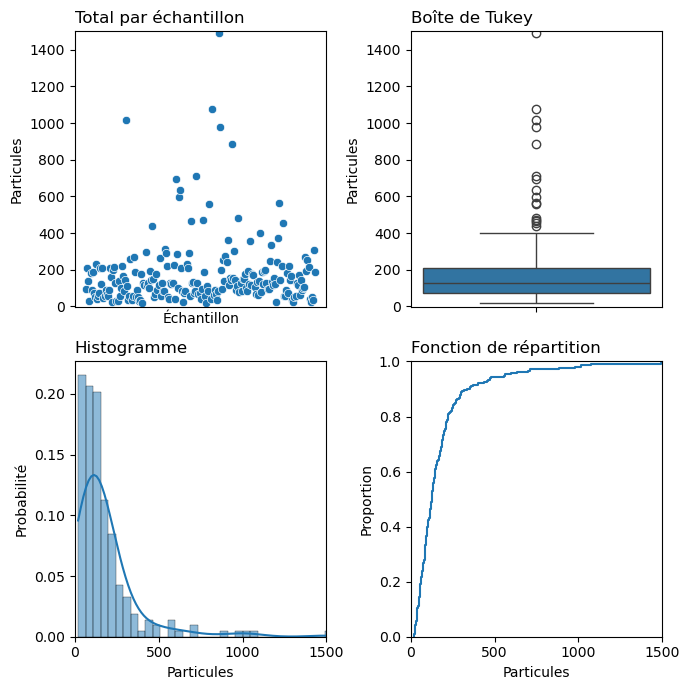

In [8]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

sns.scatterplot(data=sample_totals, x="échantillon", y="particules", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1500)
ax[0,0].set_title("Total par échantillon", loc="left")
capitalize_x_and_y_axis_labels(ax[0,0])

sns.boxplot(data=sample_totals, y="particules", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1500)
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])

sns.histplot(data=sample_totals, x="particules", ax=ax[1,0], stat="probability", kde=True)
ax[1,0].set_xlim(-1, 1500)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])

sns.ecdfplot(data=sample_totals, x="particules", ax=ax[1,1])
ax[1,1].set_xlim(-1, 1500)
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])

plt.tight_layout()
glue('fig-A12', fig, display=True)
plt.close()

```{glue:figure} fig-A12
---
name: fig-A12
---
{glue:text}`blank_caption` 
```

## Compte moyenne par position 

In [9]:
position_totals = work_data.groupby(["échantillon", "position"], as_index=False).agg({'particules': 'sum'})

column_display = {
    "count":"échantillons",
    "mean": "moyenne",
    "std": "écart type",
    "échantillon":"échantillon"
}

voi = "position"
vals = "particules"

position_summary = attribute_summary(position_totals, vals, voi, columns=column_display, labels=name_zones, as_type='float')
table_no += 1
caption = "Le résumé des totaux d'échantillons par position sur la plage."

table_five = add_table_to_page(position_summary, table_no, caption, section, page," ")
glue('tablea15', table_five, display=True)

,Échantillons,Moyenne,Écart type,Min,25%,50%,75%,Max
Ligne d'eau,111,"116,84","125,53","19,00","53,50","85,00","129,00","884,00"
Plage seche,102,"268,92","365,64","37,00","116,00","185,50","265,75","3'143,00"


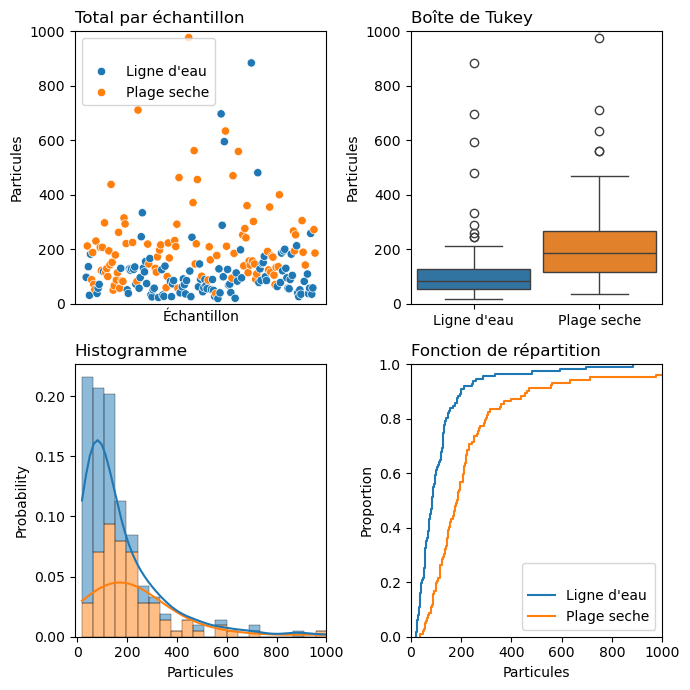

In [10]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
position_totals["position"] = position_totals.position.apply(lambda x: name_zones[x])
d_position = position_totals.groupby(["échantillon", "position"], as_index=False).particules.sum()
d_position["position"] = d_position["position"].apply(lambda x: x.capitalize())

sns.scatterplot(data=d_position, x="échantillon", y="particules", hue="position", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1000)
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].legend()
capitalize_x_and_y_axis_labels(ax[0,0])
sns.move_legend(ax[0, 0], title=" ", loc='best')

sns.boxplot(data=d_position, x="position", y="particules", hue="position", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1000)
ax[0,1].set_title("Boîte de Tukey", loc="left")
# ax[0,1].get_legend().remove()
ax[0,1].set_xlabel("")
capitalize_x_and_y_axis_labels(ax[0,1])

sns.histplot(data=d_position, x="particules", hue="position", ax=ax[1,0], multiple="stack", stat="probability", kde=True)
ax[1,0].set_xlim(-10, 1000)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_title("Histogramme", loc="left")
ax[1,0].get_legend().remove()
capitalize_x_and_y_axis_labels(ax[1,0])

sns.ecdfplot(data=d_position, x="particules", hue="position", ax=ax[1,1])
ax[1,1].set_xlim(-1, 1000)
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')


plt.tight_layout()
glue('fig-A13', fig, display=True)

plt.close()

```{glue:figure} fig-A13
---
name: fig-A13
---
{glue:text}`blank_caption` 
```

### Nombre moyen par forme et plage

In [11]:
forme_totals = work_data.groupby(["Plage","échantillon", "objet"], as_index=False).particules.sum()

average_of_sample_formes = forme_totals.groupby(["objet"], as_index=True).agg({"particules":"mean"})

# change the column name to the descriptive statisic
average_of_sample_formes.rename(columns={"particules":value_column}, inplace=True)

voi = "objet"

form_summary = attribute_summary(forme_totals, vals, voi, columns=column_display, labels=particle_groups, as_type='float')
table_six = add_table_to_page(form_summary, table_no, caption, section, page, " ")
glue("table-six", table_six, display=True)

,Échantillons,Moyenne,Écart type,Min,25%,50%,75%,Max
Fibre,213,"140,42","212,82","17,00","58,00","98,00","156,00","2'593,00"
Particule rigide,213,"24,15","58,58","0,00","4,00","11,00","25,00","696,00"
Particule souple,213,"25,10","66,95","0,00","1,00","5,00","21,00","604,00"


In [12]:
# the average sample total by form of particle
forme_averages = forme_totals.groupby(["Plage", "objet"], as_index=False).agg({"particules":"mean"})

# change the column name to the descriptive statisic
forme_averages.rename(columns={"particules":value_column}, inplace=True)

forme_averages = forme_averages.pivot(index="Plage", columns="objet").droplevel(0, axis=1)
forme_averages.index.name = None
forme_averages.rename(columns=particle_groups, inplace=True)

# identifyt the values that exceed threshold
select_fdure_values = forme_averages["Particule rigide"] > average_of_sample_formes.loc["fdure", value_column]
select_souple_values = forme_averages["Particule souple"] > average_of_sample_formes.loc["souple", value_column]
select_fiber_vales = forme_averages["Fibre"] > average_of_sample_formes.loc["fibres", value_column]

# select the the values that exceed threshold
test_three = forme_averages.loc[select_fdure_values].index
test_four = forme_averages.loc[select_souple_values].index
test_five = forme_averages.loc[select_fiber_vales].index

caption = "Le nombre moyen par échantillon par plage et forme."

forme_averages = forme_averages.style.set_table_styles(table_css_styles)

# highlight values that exceed table styles
forme_averages = forme_averages.set_properties(subset = pd.IndexSlice[test_three,["Particule rigide"]], **a_red_property)
forme_averages = forme_averages.set_properties(subset = pd.IndexSlice[test_four,["Particule souple"]], **a_red_property)
forme_averages = forme_averages.set_properties(subset = pd.IndexSlice[test_five,["Fibre"]], **a_red_property)
forme_averages.columns.name = None

table_no += 1

table_seven = add_table_to_page(forme_averages, table_no, caption, section, page, rule)
glue("table-seven", table_seven, display=True)

,Particule rigide,Fibre,Particule souple
Amphion,"7,90","110,00","10,80"
Anthy,"9,50","91,67","15,83"
Aubonne,"11,88","70,12","14,38"
Baby plage,"12,09","98,09","8,73"
Bouveret,"16,00","160,64","28,09"
Clarens,"6,33","57,50","8,00"
Crans,"2,00","17,00","0,00"
Cully,"11,00","117,00","0,00"
Excenevex,"20,04","97,14","37,07"
Gland,"8,00","26,00","6,00"


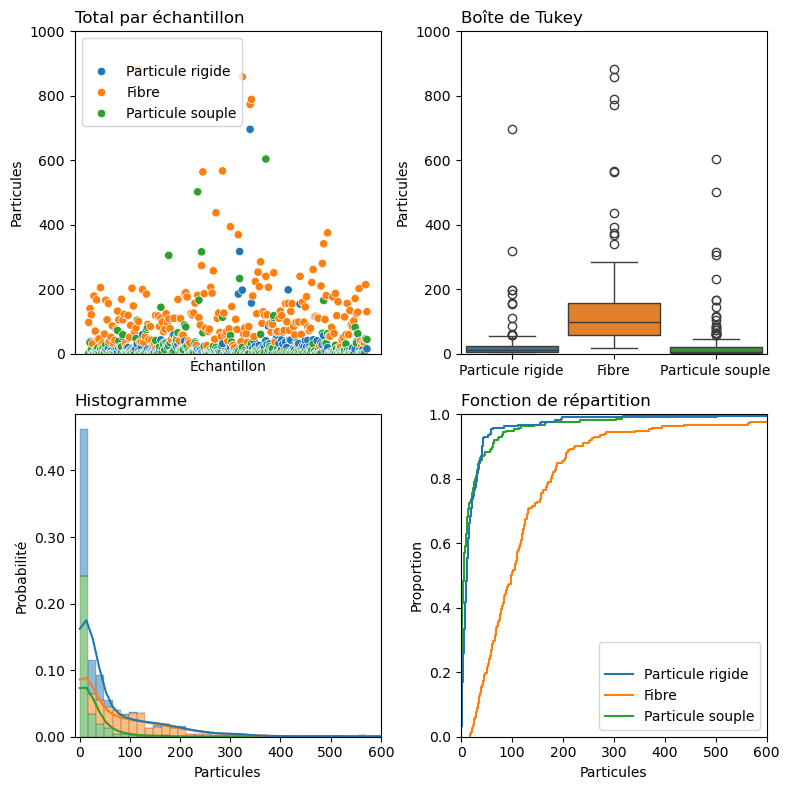

In [13]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

forme_totals["Objet"] = forme_totals["objet"].apply(lambda x: particle_groups[x])

sns.scatterplot(data=forme_totals, x="échantillon", y="particules", hue="Objet", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_ylim(-1, 1000)
ax[0,0].set_title("Total par échantillon", loc="left")
capitalize_x_and_y_axis_labels(ax[0,0])
sns.move_legend(ax[0, 0], title=" ", loc='best')

sns.boxplot(data=forme_totals, x="Objet", y="particules", hue="Objet", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_ylim(-1, 1000)
ax[0,1].set_title("Boîte de Tukey", loc="left")
ax[0,1].set_xlabel("")
capitalize_x_and_y_axis_labels(ax[0,1])
capitalize_x_tick_labels(ax[0,1])

sns.histplot(data=forme_totals, x="particules", hue="Objet", ax=ax[1,0], multiple="stack", stat="probability", kde=True)
ax[1,0].set_xlim(-10, 600)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
ax[1,0].get_legend().remove()
capitalize_x_and_y_axis_labels(ax[1,0])

sns.ecdfplot(data=forme_totals, x="particules", hue="Objet", ax=ax[1,1])
ax[1,1].set_xlim(-1, 600)
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.tight_layout()

glue('fig-A14', fig, display=True)

plt.close()

```{glue:figure} fig-A14
---
name: fig-A14
---
{glue:text}`blank_caption` 
```

### Nombre moyen par forme et position

In [14]:
ldeau_form = work_data[work_data.position == 1].groupby(["échantillon", "Plage", "position", "objet"], as_index=False).particules.sum()

ldeau_summary = attribute_summary(ldeau_form, vals, voi, columns=column_display, labels=particle_groups, as_type='float')

table_no += 1

caption = "<b>Ligne d'eau, </b> le nombre moyen de particules trouvées par échantillon selon la forme du particule."

table_eight = add_table_to_page(ldeau_summary, table_no, caption, section, page,' ')
glue("table-eight", table_eight, display=True)

,Échantillons,Moyenne,Écart type,Min,25%,50%,75%,Max
Fibre,111,"86,73","58,66","17,00","39,00","72,00","116,50","273,00"
Particule rigide,111,"12,24","16,40","0,00","2,00","7,00","14,00","112,00"
Particule souple,111,"17,86","81,22","0,00","0,00","1,00","3,50","604,00"


In [15]:
pseche_form = work_data[work_data.position == 2].groupby(["échantillon", "Plage", "position", "objet"], as_index=False).particules.sum()

psech_summary = attribute_summary(pseche_form, vals, voi, columns=column_display, labels=particle_groups, as_type='float')

table_no += 1

caption = "<b>Plage seche, </b>le nombre moyen de particules trouvées par échantillon selon la forme du particule."

table_nine = add_table_to_page(psech_summary, table_no, caption, section, page, ' ')
glue("table-nine", table_nine, display=True)

,Échantillons,Moyenne,Écart type,Min,25%,50%,75%,Max
Fibre,102,"198,84","291,05","30,00","85,00","126,50","187,75","2'593,00"
Particule rigide,102,"37,10","81,14","1,00","9,25","16,00","31,75","696,00"
Particule souple,102,"32,98","45,85","0,00","6,00","19,00","38,25","305,00"


In [16]:
position_totals_by_form = work_data.groupby(["Plage","échantillon", "position", "objet"], as_index=False).particules.sum()
position_totals_by_form["position"] = position_totals_by_form.position.apply(lambda x: name_zones[x])
position_totals_by_form["objet"] = position_totals_by_form.objet.apply(lambda x: particle_groups[x])

sax = position_totals_by_form.groupby(["Plage","position", "objet"], as_index=False).particules.mean()

sax = sax.pivot(index="Plage", columns=["position", "objet"])
sax.index.name = None
position_columns = list(name_zones.values())
fragment_columns = list(particle_groups.values())

args_one = [("particules", position_columns[0], x) for x in fragment_columns]
args_two = [("particules", position_columns[1], x) for x in fragment_columns]

args_0 = select_a_set_of_values(sax, args_one[0], list(particle_groups.keys())[0], value_column, average_of_sample_formes).index
args_1 = select_a_set_of_values(sax, args_one[1], list(particle_groups.keys())[1], value_column, average_of_sample_formes).index
args_2  = select_a_set_of_values(sax, args_one[2], list(particle_groups.keys())[2], value_column, average_of_sample_formes).index

args_2_0 = select_a_set_of_values(sax, args_two[0], list(particle_groups.keys())[0], value_column, average_of_sample_formes).index
args_2_1 = select_a_set_of_values(sax, args_two[1], list(particle_groups.keys())[1], value_column, average_of_sample_formes).index
args_2_2 = select_a_set_of_values(sax, args_two[2], list(particle_groups.keys())[2], value_column, average_of_sample_formes).index

sax = sax.style.set_table_styles(table_css_styles)
  
sax = sax.set_properties(subset = pd.IndexSlice[args_2, args_one[2]],**a_red_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_1,args_one[1]],**a_red_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_0,args_one[0]], **a_red_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_2, args_two[2]], **a_red_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_1,args_two[1]],**a_red_property)
sax = sax.set_properties(subset = pd.IndexSlice[args_2_0,args_two[0]], **a_red_property)

table_no += 1

caption = "le nombre moyen de particules trouvées par plage selon la forme du particule et la position."

table_ten = add_table_to_page(sax, table_no, caption, section, page, ' ')
glue("table-ten", table_ten, display=True)

### Distributions



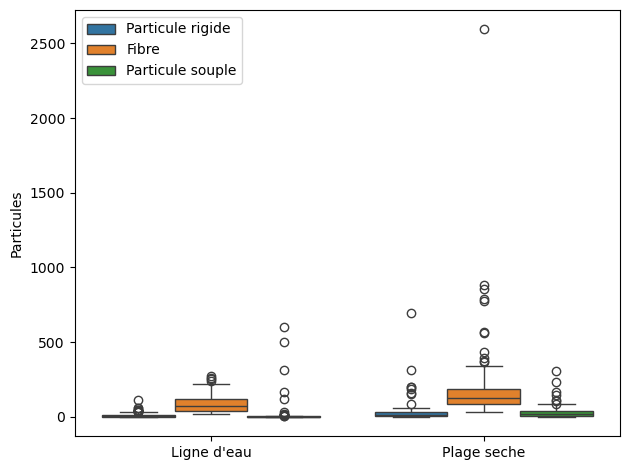

In [17]:
fig, ax = plt.subplots(1)

sns.boxplot(data=position_totals_by_form, x="position", y="particules", hue="objet", ax=ax)

ax.set_xlabel("")
capitalize_x_and_y_axis_labels(ax)
capitalize_x_tick_labels(ax)
capitalize_legend_components(ax)

plt.tight_layout()
glue('fig-A15', fig, display=True)

plt.close()

```{glue:figure} fig-A15
---
name: fig-A15
---
{glue:text}`blank_caption` 
```

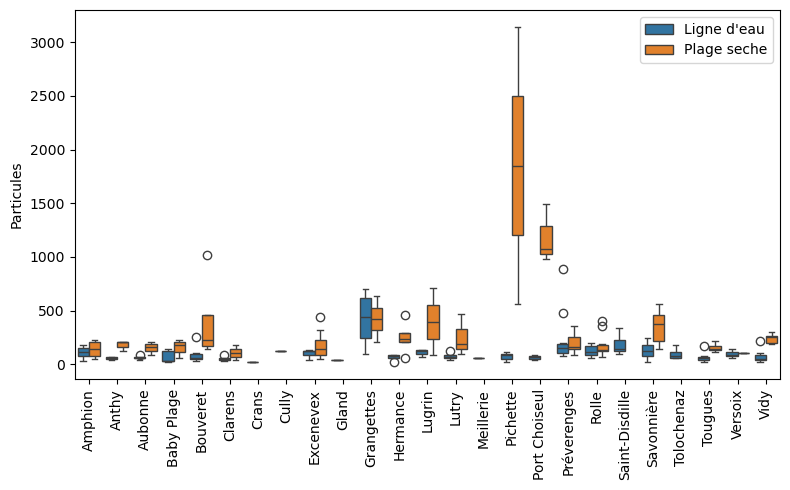

In [18]:
position_totals = work_data.groupby(["Plage","échantillon", "position"], as_index=False).particules.sum()
position_totals["position"] = position_totals.position.apply(lambda x: name_zones[x])

fig, ax = plt.subplots(1, figsize=(8,5))

sns.boxplot(data=position_totals, x="Plage", y="particules", hue="position", ax=ax)

ax.set_xlabel("")
ax.tick_params(axis="x", labelrotation=90)
capitalize_x_and_y_axis_labels(ax)
capitalize_legend_components(ax)

plt.tight_layout()
glue('fig-A16', fig, display=True)

plt.close()

```{glue:figure} fig-A16
---
name: fig-A16
---
{glue:text}`blank_caption` 
```

In [19]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: feb22

seaborn   : 0.13.1
matplotlib: 3.8.2
pandas    : 2.0.3
numpy     : 1.26.3

